
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/analysis_3d.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[analysis_3d.ipynb](../_static/notebooks/analysis_3d.ipynb) |
[analysis_3d.py](../_static/notebooks/analysis_3d.py)
</div>


# 3D detailed analysis

This tutorial does a 3D map based analsis on the galactic center, using simulated observations from the CTA-1DC. We will use the high level interface for the data reduction, and then do a detailed modelling. This will be done in two different ways:

- stacking all the maps together and fitting the stacked maps
- handling all the observations separately and doing a joint fitting on all the maps

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from pathlib import Path
from regions import CircleSkyRegion
from scipy.stats import norm
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.estimators import ExcessMapEstimator
from gammapy.datasets import MapDataset

## Analysis configuration

In this section we select observations and define the analysis geometries, irrespective of  joint/stacked analysis. For configuration of the analysis, we will programatically build a config file from scratch.

In [2]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
                energy_true: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
            parameters: {}
        safe_m

In [3]:
# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

In [4]:
# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.fov = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true enery binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

In [5]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/cta-1dc/index/gps
        obs_ids: [110380, 111140, 111159]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 0.0 deg, lat: 0.0 deg}
                binsize: 0.02 deg
                fov: {width: 10.0 deg, height: 8.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.08 TeV, max: 12.0 TeV, nbins: 14}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
  

## Configuration for stacked and joint analysis

This is done just by specfiying the flag on `config.datasets.stack`. Since the internal machinery will work differently for the two cases, we will write it as two config files and save it to disc in YAML format for future reference. 

In [6]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [7]:
# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_joint.write(path=path / "config_joint.yaml", overwrite=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

## Stacked analysis

### Data reduction

We first show the steps for the stacked analysis and then repeat the same for the joint analysis later


In [8]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

In [9]:
analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [10]:
%%time
# select observations:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Number of selected observations: 3
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 110380
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No thresholds defined for obs 110380
Processing observation 111140
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No thresholds defined for obs 111140
Processing observation 111159
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No thresholds defined for obs 111159


CPU times: user 10.6 s, sys: 3 s, total: 13.6 s
Wall time: 13.6 s


We have one final dataset, which you can print and explore

In [11]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 121241 
  Total background counts         : 108043.52
  Total excess counts             : 13197.48

  Predicted counts                : 108043.52
  Predicted background counts     : 108043.52
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1411180 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [12]:
# To plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [13]:
# And the background map
dataset_stacked.background.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7f2dc7ffe9e8>)

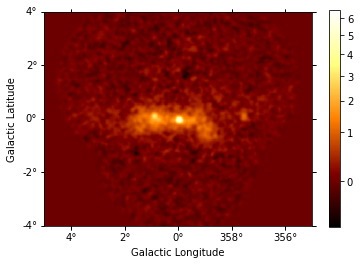

In [14]:
# You can also get an excess image with a few lines of code:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

### Modeling and fitting

Now comes the interesting part of the analysis - choosing appropriate models for our source and fitting them.

We choose a point source model with an exponential cutoff power-law spectrum.

To select a certain energy range for the fit we can create a fit mask:

In [15]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.3 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(
    geom=dataset_stacked.counts.geom, data=mask_energy
)

In [16]:
spatial_model = PointSpatialModel(
    lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.spectral_model.norm.value = 1.3

models_stacked = Models([model, bkg_model])

dataset_stacked.models = models_stacked

In [17]:
%%time
fit = Fit([dataset_stacked])
result = fit.run(optimize_opts={"print_level": 1})

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.802e+05                  │        Nfcn = 190 (190 total)        │
│ EDM = 7.89e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
CPU times: user 7.62 s, sys: 5.02 ms, total: 7.62 s
Wall time: 7.62 s


### Fit quality assesment and model residuals for a `MapDataset`

We can access the results dictionary to see if the fit converged:

In [18]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 190
	total stat : 280224.32



Check best-fit parameters and error estimates:

In [19]:
result.parameters.to_table()

type,name,value,unit,min,max,frozen,error
str8,str9,float64,str14,float64,float64,bool,float64
spectral,index,2.2652e+00,,nan,nan,False,1.158e-01
spectral,amplitude,2.8132e-12,cm-2 s-1 TeV-1,nan,nan,False,3.269e-13
spectral,reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
spectral,lambda_,4.0388e-02,TeV-1,nan,nan,False,6.232e-02
spectral,alpha,1.0000e+00,,nan,nan,True,0.000e+00
spatial,lon_0,-5.2014e-02,deg,nan,nan,False,2.260e-03
spatial,lat_0,-5.2730e-02,deg,-9.000e+01,9.000e+01,False,2.166e-03
spectral,norm,1.2480e+00,,nan,nan,False,6.448e-03
spectral,tilt,0.0000e+00,,nan,nan,True,0.000e+00


A quick way to inspect the model residuals is using the function `~MapDataset.plot_residuals_spatial()`. This function computes and plots a residual image (by default, the smoothing radius is `0.1 deg` and `method=diff`, which corresponds to a simple `data - model` plot):

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

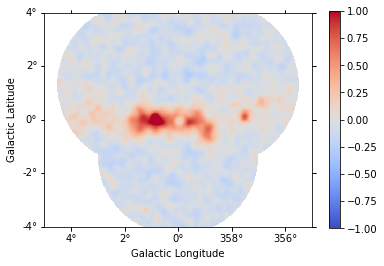

In [20]:
dataset_stacked.plot_residuals_spatial(
    method="diff/sqrt(model)", vmin=-1, vmax=1
);

The more general function `~MapDataset.plot_residuals()` can also extract and display spectral residuals in a region:

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

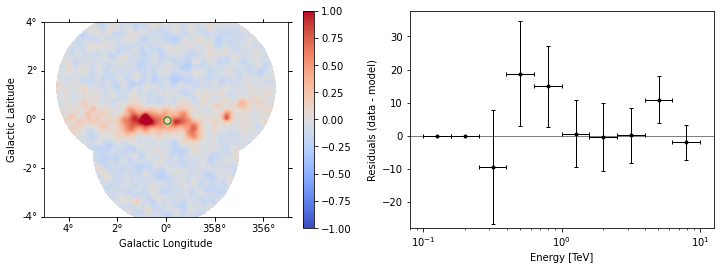

In [21]:
region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)

dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
);

This way of accessing residuals is quick and handy, but comes with limitations. For example:
- In case a fitting energy range was defined using a `MapDataset.mask_fit`, it won't be taken into account. Residuals will be summed up over the whole reconstructed energy range
- In order to make a proper statistic treatment, instead of simple residuals a proper residuals significance map should be computed

A more accurate way to inspect spatial residuals is the following:

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


array([<WCSAxesSubplot:title={'center':'Energy 0.1 TeV - 1.0 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
       <WCSAxesSubplot:title={'center':'Energy 1.0 TeV - 10.0 TeV '}, xlabel='Galactic Longitude'>],
      dtype=object)

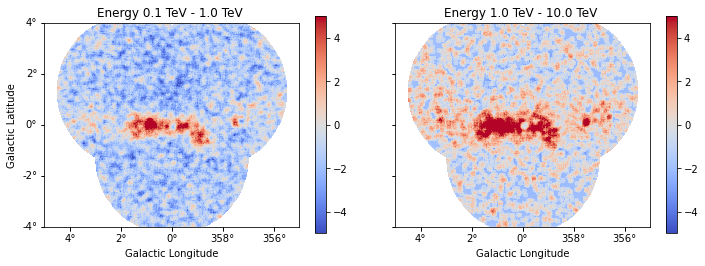

In [22]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
)

result = estimator.run(dataset_stacked)

result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
);

Distribution of residuals significance in the full map geometry:

(-5.0, 5.0)

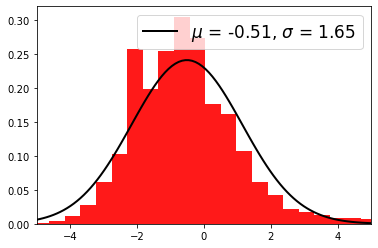

In [23]:
# TODO: clean this up
significance_data = result["sqrt_ts"].data

# #Remove bins that are inside an exclusion region, that would create an artificial peak at significance=0.
# #For now these lines are useless, because to_image() drops the mask fit
# mask_data = dataset_image.mask_fit.sum_over_axes().data
# excluded = mask_data == 0
# significance_data = significance_data[~excluded]
selection = np.isfinite(significance_data) & ~(significance_data == 0)
significance_data = significance_data[selection]

plt.hist(significance_data, density=True, alpha=0.9, color="red", bins=40)
mu, std = norm.fit(significance_data)

x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)

plt.plot(
    x,
    p,
    lw=2,
    color="black",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std),
)
plt.legend(fontsize=17)
plt.xlim(-5, 5)

## Joint analysis

In this section, we perform a joint analysis of the same data. Of course, joint fitting is considerably heavier than stacked one, and should always be handled with care. For brevity, we only show the analysis for a point source fitting without re-adding a diffuse component again. 

### Data reduction

In [24]:
%%time

# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=path / "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 3
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 110380
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No thresholds defined for obs 110380
Processing observation 111140
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No thresholds defined for obs 111140
Processing observation 111159
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table!

CPU times: user 10.8 s, sys: 3.08 s, total: 13.9 s
Wall time: 13.9 s


In [25]:
# You can see there are 3 datasets now
print(analysis_joint.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : 08nJFuib
  Instrument : CTA
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : lBSkmWVr
  Instrument : CTA
  Models     : 

Dataset 2: 

  Type       : MapDataset
  Name       : OSEUjUYx
  Instrument : CTA
  Models     : 




In [26]:
# You can access each one by name or by index, eg:
print(analysis_joint.datasets[0])

MapDataset
----------

  Name                            : 08nJFuib 

  Total counts                    : 40481 
  Total background counts         : 36014.51
  Total excess counts             : 4466.49

  Predicted counts                : 36014.51
  Predicted background counts     : 36014.51
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 6.68e+09 m2 s

  Number of total bins            : 1085000 
  Number of fit bins              : 693940 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




After the data reduction stage, it is nice to get a quick summary info on the datasets. 
Here, we look at the statistics in the center of Map, by passing an appropriate `region`. To get info on the entire spatial map, omit the region argument.

In [27]:
analysis_joint.datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str8,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,40481.0,36014.515625,4466.484375,23.0727068890068,36014.50696021132,36014.515625,nan,62838924.0,6676807680.0,nan,1800.0,nan,nan,nan,1085000,693940,cash,nan
lBSkmWVr,40525.0,36014.49447680409,4510.505523195912,23.296190542858564,36014.49447680409,36014.49447680409,nan,62838194.40985183,6676808531.80466,nan,1800.0,nan,nan,nan,1085000,693940,cash,nan
OSEUjUYx,40235.0,36014.51944503384,4220.480554966161,21.82468013655675,36014.51944503384,36014.51944503384,nan,62838404.53574622,6676813626.917054,nan,1800.0,nan,nan,nan,1085000,693940,cash,nan


In [28]:
models_joint = Models()

model_joint = model.copy(name="source-joint")
models_joint.append(model_joint)

for dataset in analysis_joint.datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models_joint.append(bkg_model)

print(models_joint)

Models

Component 0: SkyModel

  Name                      : source-joint
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.265              
    amplitude               :   2.81e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.040  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  -0.052  deg         
    lat_0                   :  -0.053  deg         

Component 1: FoVBackgroundModel

  Name                      : 08nJFuib-bkg
  Datasets names            : ['08nJFuib']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBack

In [29]:
# and set the new model
analysis_joint.datasets.models = models_joint

In [30]:
%%time
fit_joint = Fit(analysis_joint.datasets)
result_joint = fit_joint.run()

CPU times: user 14.8 s, sys: 90.2 ms, total: 14.9 s
Wall time: 14.9 s


### Fit quality assessment and model residuals for a joint `Datasets` 

We can access the results dictionary to see if the fit converged:

In [31]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 208
	total stat : 748254.88



Check best-fit parameters and error estimates:

In [32]:
print(models_joint)

Models

Component 0: SkyModel

  Name                      : source-joint
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.275              
    amplitude               :   2.85e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.038  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  -0.053  deg         
    lat_0                   :  -0.053  deg         

Component 1: FoVBackgroundModel

  Name                      : 08nJFuib-bkg
  Datasets names            : ['08nJFuib']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.117              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBack

Since the joint dataset is made of multiple datasets, we can either:
- Look at the residuals for each dataset separately. In this case, we can directly refer to the section `Fit quality and model residuals for a MapDataset` in this notebook
- Look at a stacked residual map. 

In the latter case, we need to properly stack the joint dataset before computing the residuals:

In [33]:
# TODO: clean this up

# We need to stack on the full geometry, so we use to geom from the stacked counts map.
stacked = MapDataset.from_geoms(**dataset_stacked.geoms)

for dataset in analysis_joint.datasets:
    # TODO: Apply mask_fit before stacking
    stacked.stack(dataset)

stacked.models = [model_joint]

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

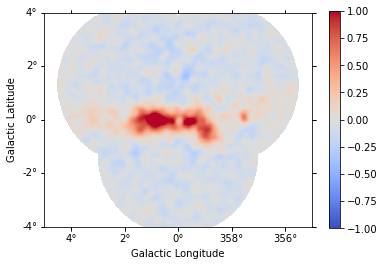

In [34]:
stacked.plot_residuals_spatial(vmin=-1, vmax=1);

Then, we can access the stacked model residuals as previously shown in the section `Fit quality and model residuals for a MapDataset` in this notebook.

Finally, let us compare the spectral results from the stacked and joint fit:

In [35]:
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.3, 10] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:388: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:389: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:388: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-d

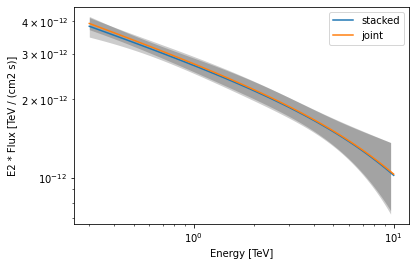

In [36]:
plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
plt.legend()

## Summary

Note that this notebook aims to show you the procedure of a 3D analysis using just a few observations. Results get much better for a more complete analysis considering the GPS dataset from the CTA First Data Challenge (DC-1) and also the CTA model for the Galactic diffuse emission, as shown in the next image:

![](images/DC1_3d.png)

The complete tutorial notebook of this analysis is available to be downloaded in [GAMMAPY-EXTRA](https://github.com/gammapy/gammapy-extra) repository at https://github.com/gammapy/gammapy-extra/blob/master/analyses/cta_1dc_gc_3d.ipynb).

## Exercises

* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.
* Perform modeling in more details - Add diffuse component, get flux points.